In [57]:
import pandas as pd
import os
import numpy as np
#from IPython.core.display_functions import clear_output
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from datetime import datetime
import time
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

In [58]:
DATA_PATH = '../../Pokemon-data/'
NORMALIZED_DATA = '../../Training-baseline/'
AUGMENTATION_PATH = '../../pipe_one_aug/'
CSV_NAME = "aug-training-list.csv"
SEED = 42
BATCH_SIZE = 64
EPOCHS = 20
MODEL_NAME = "aug-freeze-customLR"
checkpoint_path = './saved-models/'
TRAINING_METRICS = './training-metrics/'
n_epochs_stop = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [59]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
        # use the slice to remove a possible 4th alpha channel
		image = np.load(img_path)[:,:,:3]
		image = image.astype(np.float32)
		label = self.y[idx]
		return image, label

In [60]:
def stratified_split(dataset, labels):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  labels,
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    trainSet = CustomDataset(x_train, y_train, AUGMENTATION_PATH)
    valSet = CustomDataset(x_val, y_val, AUGMENTATION_PATH)
    return trainSet, valSet

In [61]:
def print_performance_metrics(currentEpoch, avgTrainLoss, trainCorrect, avgValLoss, valCorrect, trainf1, valf1):
    print(f"---------------------------------------------------- ")
    print(f"[INFO] EPOCH: {currentEpoch + 1}/{EPOCHS}")
    print(f"Train loss: {avgTrainLoss :.6f}, Train accuracy: {trainCorrect :.4f}")
    print(f"Val loss: 	{avgValLoss :.6f}, Val accuracy:   {valCorrect :.4f}")
    print(f"Train F1: 	{trainf1 :.6f}")
    print(f"Val F1: 	{valf1 :.6f}")
    print(f"---------------------------------------------------- \n")

In [62]:
# read data
csv_data = pd.read_csv(f"./metadata/{CSV_NAME}", index_col=0)

y_train = np.zeros((len(csv_data["y_train_columns"]),csv_data["y_train_columns"][0]))
for i in range(csv_data["y_train_columns"][0]):
    y_train[:,i] = csv_data["y_train"+str(i)]

encoded_data = csv_data.drop(csv_data.columns[(csv_data.shape[1]-csv_data["y_train_columns"][0]-1):csv_data.shape[1]], axis=1)

In [63]:
train, val = stratified_split(encoded_data, y_train)
trainDataLoader = DataLoader(train, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(val, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [64]:
def get_baseline_model():
    model = models.efficientnet_b0(pretrained=False)
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [65]:
def get_pretrained_frozen_model():
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [66]:
def get_pretrained_half_frozen_model():
    model = models.efficientnet_b0(pretrained=True)

    # freeze all BatchNorm layers
    for name ,child in (model.named_children()):
        if not isinstance(child, nn.BatchNorm2d):
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False

    # freeze first 5 layers
    for i in range(5):
        for param in model.features[i].parameters():
            param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [67]:
def get_pretrained_model():
    model = models.efficientnet_b0(pretrained=True)

    # freeze all BatchNorm layers
    for name ,child in (model.named_children()):
        if not isinstance(child, nn.BatchNorm2d):
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [68]:
#call model function for specific strategy
model = get_pretrained_frozen_model()

In [69]:
torch.manual_seed(SEED)
class_acc = []
epochs_no_improve = 0
metrics = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": [],
	"trainf1": [],
    "valf1": []
}

In [70]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

In [71]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()
min_val_loss = 100
early_stopping = False

for epoch in range(EPOCHS):
    epoch_start = time.time()
    print(f"[INFO] starting training for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")

    train_preds = []
    train_target = []

    val_preds = []
    val_target = []

    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    for data, targets in tqdm(trainDataLoader, desc="Training progress"):
        data = data.transpose(1, 3)
        data = data.transpose(2, 3)

        optimizer.zero_grad()

        data = data.float()
        data, targets = (data.to(device), targets.to(device))
        # Generate predictions
        out = model(data)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss

        for item in out:
            train_preds.append(np.argmax(item.cpu().detach().numpy()))
            trainCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

        for label in targets:
            train_target.append(label.cpu().detach().numpy().argmax(0))

    with torch.no_grad():
        model.eval()
        print(f"[INFO] starting evaluation for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")
        for data, targets in tqdm(valDataLoader, desc="Validation progress"):
            data = data.transpose(1, 3)
            data = data.transpose(2, 3)

            data = data.float()
            data, targets = (data.to(device), targets.to(device))
            # Generate predictions
            out = model(data)
            # Calculate loss
            totalValLoss += criterion(out, targets)
            for item in out:
                val_preds.append(np.argmax(item.cpu().detach().numpy()))
                valCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

            for label in targets:
                val_target.append(label.cpu().detach().numpy().argmax(0))

        # Average validation loss
        avg_val_loss = totalValLoss / valSteps
        # If the validation loss is at a minimum
        if avg_val_loss < min_val_loss:
            # Save the model
            torch.save(model, checkpoint_path + MODEL_NAME + ".pt")
            epochs_no_improve = 0
            min_val_loss = avg_val_loss

        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                early_stopping = True

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps

    # calculate per class accuracy via confusion matrix
    matrix = confusion_matrix(val_target, val_preds)
    class_acc.append(matrix.diagonal() / matrix.sum(axis=1))

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # calculate macro F1 score
    trainf1 = f1_score(train_target, train_preds, average='macro')
    valf1 = f1_score(val_target, val_preds, average="macro")

    # update our training history
    metrics["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    metrics["train_acc"].append(trainCorrect)
    metrics["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    metrics["val_acc"].append(valCorrect)
    metrics['trainf1'].append(trainf1)
    metrics['valf1'].append(valf1)

    # print the model training and validation information
    #clear_output()
    print_performance_metrics(epoch, avgTrainLoss, trainCorrect, avg_val_loss, valCorrect, trainf1, valf1)

    # save performance metrics for each epoch during training
    metrics_file = pd.DataFrame.from_dict(metrics)
    metrics_file.to_csv(TRAINING_METRICS + MODEL_NAME + ".csv")

    epoch_end = time.time()
    print(f"[INFO] Epoch took {(epoch_end - epoch_start) / 60 :.2f}min")


    if early_stopping:
        print(f"Early stopping after {epoch + 1} Epochs")
        break

endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

[INFO] training the network...
[INFO] starting training for epoch: 1 at 16:44:22


Training progress: 100%|██████████| 294/294 [07:45<00:00,  1.58s/it]


[INFO] starting evaluation for epoch: 1 at 16:52:07


Validation progress: 100%|██████████| 98/98 [01:00<00:00,  1.61it/s]


---------------------------------------------------- 
[INFO] EPOCH: 1/20
Train loss: 2.582059, Train accuracy: 0.6105
Val loss: 	2.287955, Val accuracy:   0.5427
Train F1: 	0.139134
Val F1: 	0.221529
---------------------------------------------------- 

[INFO] Epoch took 8.77min
[INFO] starting training for epoch: 2 at 16:53:08


Training progress: 100%|██████████| 294/294 [05:44<00:00,  1.17s/it]


[INFO] starting evaluation for epoch: 2 at 16:58:52


Validation progress: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]


---------------------------------------------------- 
[INFO] EPOCH: 2/20
Train loss: 2.154556, Train accuracy: 0.5858
Val loss: 	1.958951, Val accuracy:   0.5495
Train F1: 	0.243567
Val F1: 	0.320849
---------------------------------------------------- 

[INFO] Epoch took 6.32min
[INFO] starting training for epoch: 3 at 16:59:27


Training progress: 100%|██████████| 294/294 [06:18<00:00,  1.29s/it]


[INFO] starting evaluation for epoch: 3 at 17:05:45


Validation progress: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s]


---------------------------------------------------- 
[INFO] EPOCH: 3/20
Train loss: 1.926331, Train accuracy: 0.5896
Val loss: 	1.774623, Val accuracy:   0.5632
Train F1: 	0.316727
Val F1: 	0.377687
---------------------------------------------------- 

[INFO] Epoch took 6.86min
[INFO] starting training for epoch: 4 at 17:06:19


Training progress: 100%|██████████| 294/294 [06:13<00:00,  1.27s/it]


[INFO] starting evaluation for epoch: 4 at 17:12:33


Validation progress: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]


---------------------------------------------------- 
[INFO] EPOCH: 4/20
Train loss: 1.782723, Train accuracy: 0.5984
Val loss: 	1.650774, Val accuracy:   0.5738
Train F1: 	0.360054
Val F1: 	0.417720
---------------------------------------------------- 

[INFO] Epoch took 6.75min
[INFO] starting training for epoch: 5 at 17:13:04


Training progress: 100%|██████████| 294/294 [06:13<00:00,  1.27s/it]


[INFO] starting evaluation for epoch: 5 at 17:19:17


Validation progress: 100%|██████████| 98/98 [00:30<00:00,  3.16it/s]


---------------------------------------------------- 
[INFO] EPOCH: 5/20
Train loss: 1.685049, Train accuracy: 0.6033
Val loss: 	1.563948, Val accuracy:   0.5803
Train F1: 	0.396219
Val F1: 	0.442660
---------------------------------------------------- 

[INFO] Epoch took 6.74min
[INFO] starting training for epoch: 6 at 17:19:48


Training progress: 100%|██████████| 294/294 [06:13<00:00,  1.27s/it]


[INFO] starting evaluation for epoch: 6 at 17:26:01


Validation progress: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


---------------------------------------------------- 
[INFO] EPOCH: 6/20
Train loss: 1.604460, Train accuracy: 0.6113
Val loss: 	1.493540, Val accuracy:   0.5865
Train F1: 	0.423713
Val F1: 	0.467154
---------------------------------------------------- 

[INFO] Epoch took 6.75min
[INFO] starting training for epoch: 7 at 17:26:33


Training progress: 100%|██████████| 294/294 [06:10<00:00,  1.26s/it]


[INFO] starting evaluation for epoch: 7 at 17:32:44


Validation progress: 100%|██████████| 98/98 [00:31<00:00,  3.12it/s]


---------------------------------------------------- 
[INFO] EPOCH: 7/20
Train loss: 1.540963, Train accuracy: 0.6201
Val loss: 	1.436736, Val accuracy:   0.5912
Train F1: 	0.441294
Val F1: 	0.481621
---------------------------------------------------- 

[INFO] Epoch took 6.71min
[INFO] starting training for epoch: 8 at 17:33:15


Training progress: 100%|██████████| 294/294 [06:07<00:00,  1.25s/it]


[INFO] starting evaluation for epoch: 8 at 17:39:23


Validation progress: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]


---------------------------------------------------- 
[INFO] EPOCH: 8/20
Train loss: 1.483121, Train accuracy: 0.6186
Val loss: 	1.389093, Val accuracy:   0.5918
Train F1: 	0.466988
Val F1: 	0.497949
---------------------------------------------------- 

[INFO] Epoch took 6.63min
[INFO] starting training for epoch: 9 at 17:39:53


Training progress: 100%|██████████| 294/294 [05:51<00:00,  1.20s/it]


[INFO] starting evaluation for epoch: 9 at 17:45:45


Validation progress: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


---------------------------------------------------- 
[INFO] EPOCH: 9/20
Train loss: 1.424961, Train accuracy: 0.6189
Val loss: 	1.343862, Val accuracy:   0.5972
Train F1: 	0.485650
Val F1: 	0.513134
---------------------------------------------------- 

[INFO] Epoch took 6.39min
[INFO] starting training for epoch: 10 at 17:46:16


Training progress: 100%|██████████| 294/294 [06:30<00:00,  1.33s/it]


[INFO] starting evaluation for epoch: 10 at 17:52:47


Validation progress: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]


---------------------------------------------------- 
[INFO] EPOCH: 10/20
Train loss: 1.389052, Train accuracy: 0.6241
Val loss: 	1.307765, Val accuracy:   0.5996
Train F1: 	0.497304
Val F1: 	0.527038
---------------------------------------------------- 

[INFO] Epoch took 7.03min
[INFO] starting training for epoch: 11 at 17:53:18


Training progress: 100%|██████████| 294/294 [06:14<00:00,  1.27s/it]


[INFO] starting evaluation for epoch: 11 at 17:59:32


Validation progress: 100%|██████████| 98/98 [00:31<00:00,  3.14it/s]


---------------------------------------------------- 
[INFO] EPOCH: 11/20
Train loss: 1.349378, Train accuracy: 0.6232
Val loss: 	1.277730, Val accuracy:   0.5985
Train F1: 	0.513659
Val F1: 	0.536694
---------------------------------------------------- 

[INFO] Epoch took 6.76min
[INFO] starting training for epoch: 12 at 18:00:03


Training progress: 100%|██████████| 294/294 [06:29<00:00,  1.33s/it]


[INFO] starting evaluation for epoch: 12 at 18:06:33


Validation progress: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]


---------------------------------------------------- 
[INFO] EPOCH: 12/20
Train loss: 1.309189, Train accuracy: 0.6262
Val loss: 	1.243533, Val accuracy:   0.5991
Train F1: 	0.529555
Val F1: 	0.552139
---------------------------------------------------- 

[INFO] Epoch took 7.03min
[INFO] starting training for epoch: 13 at 18:07:05


Training progress: 100%|██████████| 294/294 [06:16<00:00,  1.28s/it]


[INFO] starting evaluation for epoch: 13 at 18:13:22


Validation progress: 100%|██████████| 98/98 [00:30<00:00,  3.18it/s]


---------------------------------------------------- 
[INFO] EPOCH: 13/20
Train loss: 1.281358, Train accuracy: 0.6310
Val loss: 	1.219053, Val accuracy:   0.6081
Train F1: 	0.541513
Val F1: 	0.560692
---------------------------------------------------- 

[INFO] Epoch took 6.79min
[INFO] starting training for epoch: 14 at 18:13:53


Training progress: 100%|██████████| 294/294 [05:28<00:00,  1.12s/it]


[INFO] starting evaluation for epoch: 14 at 18:19:22


Validation progress: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]


---------------------------------------------------- 
[INFO] EPOCH: 14/20
Train loss: 1.247257, Train accuracy: 0.6268
Val loss: 	1.194280, Val accuracy:   0.6097
Train F1: 	0.548853
Val F1: 	0.565483
---------------------------------------------------- 

[INFO] Epoch took 6.00min
[INFO] starting training for epoch: 15 at 18:19:53


Training progress: 100%|██████████| 294/294 [05:23<00:00,  1.10s/it]


[INFO] starting evaluation for epoch: 15 at 18:25:17


Validation progress: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]


---------------------------------------------------- 
[INFO] EPOCH: 15/20
Train loss: 1.218550, Train accuracy: 0.6324
Val loss: 	1.171870, Val accuracy:   0.6074
Train F1: 	0.559551
Val F1: 	0.571844
---------------------------------------------------- 

[INFO] Epoch took 5.88min
[INFO] starting training for epoch: 16 at 18:25:46


Training progress: 100%|██████████| 294/294 [05:27<00:00,  1.11s/it]


[INFO] starting evaluation for epoch: 16 at 18:31:13


Validation progress: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]


---------------------------------------------------- 
[INFO] EPOCH: 16/20
Train loss: 1.194802, Train accuracy: 0.6277
Val loss: 	1.149684, Val accuracy:   0.6111
Train F1: 	0.566468
Val F1: 	0.580046
---------------------------------------------------- 

[INFO] Epoch took 5.96min
[INFO] starting training for epoch: 17 at 18:31:43


Training progress: 100%|██████████| 294/294 [05:28<00:00,  1.12s/it]


[INFO] starting evaluation for epoch: 17 at 18:37:12


Validation progress: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]


---------------------------------------------------- 
[INFO] EPOCH: 17/20
Train loss: 1.171642, Train accuracy: 0.6281
Val loss: 	1.130318, Val accuracy:   0.6066
Train F1: 	0.573578
Val F1: 	0.583659
---------------------------------------------------- 

[INFO] Epoch took 5.97min
[INFO] starting training for epoch: 18 at 18:37:42


Training progress: 100%|██████████| 294/294 [05:28<00:00,  1.12s/it]


[INFO] starting evaluation for epoch: 18 at 18:43:10


Validation progress: 100%|██████████| 98/98 [00:30<00:00,  3.26it/s]


---------------------------------------------------- 
[INFO] EPOCH: 18/20
Train loss: 1.142465, Train accuracy: 0.6331
Val loss: 	1.112210, Val accuracy:   0.6089
Train F1: 	0.581836
Val F1: 	0.590877
---------------------------------------------------- 

[INFO] Epoch took 5.98min
[INFO] starting training for epoch: 19 at 18:43:41


Training progress: 100%|██████████| 294/294 [05:35<00:00,  1.14s/it]


[INFO] starting evaluation for epoch: 19 at 18:49:16


Validation progress: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]


---------------------------------------------------- 
[INFO] EPOCH: 19/20
Train loss: 1.120670, Train accuracy: 0.6235
Val loss: 	1.096125, Val accuracy:   0.6127
Train F1: 	0.591019
Val F1: 	0.594250
---------------------------------------------------- 

[INFO] Epoch took 6.08min
[INFO] starting training for epoch: 20 at 18:49:46


Training progress: 100%|██████████| 294/294 [05:31<00:00,  1.13s/it]


[INFO] starting evaluation for epoch: 20 at 18:55:17


Validation progress: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]

---------------------------------------------------- 
[INFO] EPOCH: 20/20
Train loss: 1.099802, Train accuracy: 0.6279
Val loss: 	1.076166, Val accuracy:   0.6114
Train F1: 	0.599077
Val F1: 	0.599114
---------------------------------------------------- 

[INFO] Epoch took 6.02min
[INFO] total time taken to train the model: 131.41min


In [72]:
metrics = pd.DataFrame.from_dict(metrics)
metrics.to_csv(TRAINING_METRICS + MODEL_NAME + ".csv")

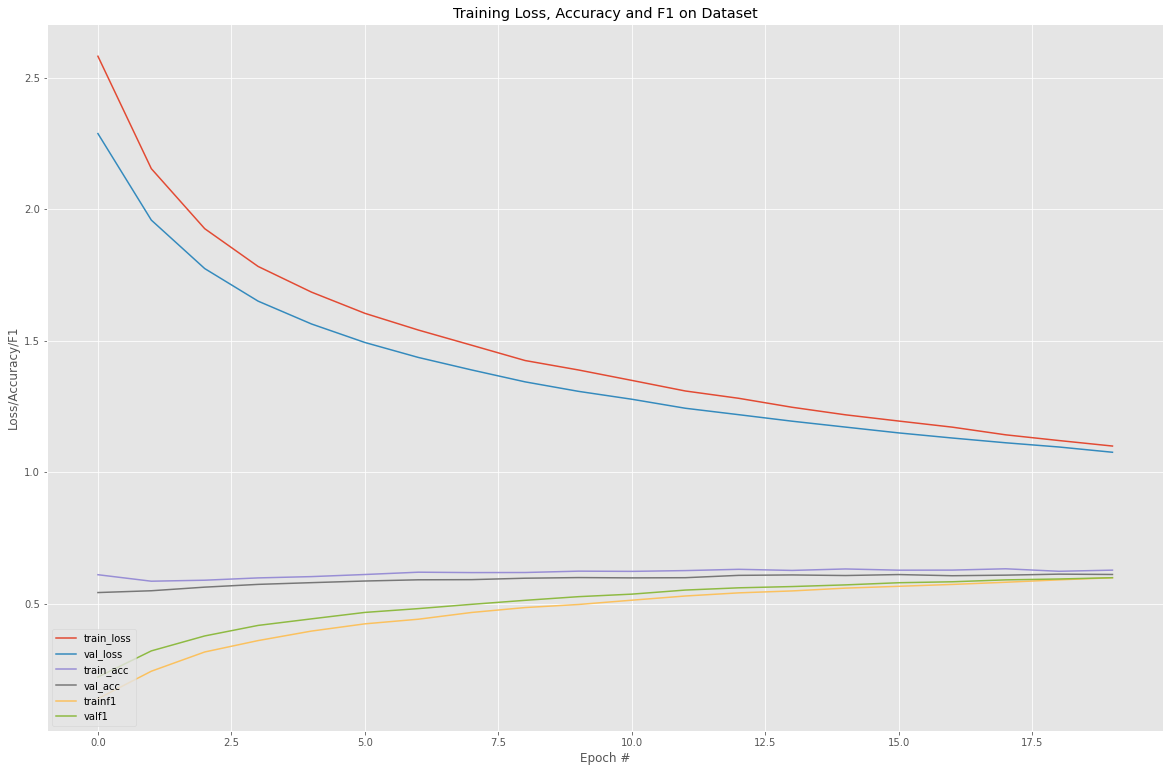

In [73]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 13))
plt.plot(metrics["train_loss"], label="train_loss")
plt.plot(metrics["val_loss"], label="val_loss")
plt.plot(metrics["train_acc"], label="train_acc")
plt.plot(metrics["val_acc"], label="val_acc")
plt.plot(metrics["trainf1"], label="trainf1")
plt.plot(metrics["valf1"], label="valf1")
plt.title("Training Loss, Accuracy and F1 on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(loc="lower left")

In [74]:
torch.cuda.empty_cache()